In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


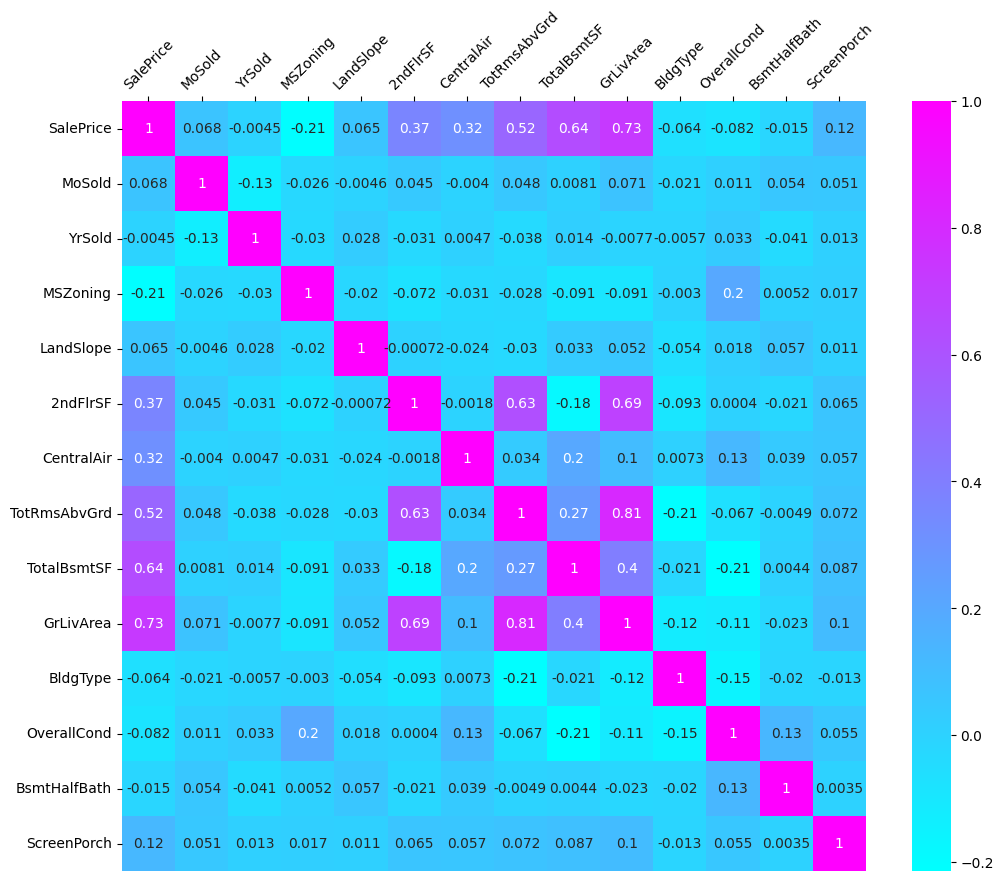

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import seaborn as sns


def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    """
    This function splits a DataFrame into:
    - training set
    - validation set
    - test set
    """

    np.random.seed(seed)

    perm = np.random.permutation(df.index)
    m = len(df.index)

    train_end = int(np.floor(train_percent * m))
    validate_end = int(np.floor(train_end + validate_percent * m))


    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]

    train = train.drop(columns=["index"])
    validate = validate.drop(columns=["index"])
    test = test.drop(columns=["index"])

    train = train.reset_index(drop=True)
    validate = validate.reset_index(drop=True)
    test = test.reset_index(drop=True)

    return train, validate, test


# Folder where the dataset is stored
# foldername = "house-prices-advanced-regression-techniques"
# Read the CSV file into a DataFrame
# df = pd.read_csv('%s/train.csv' % foldername)
df = pd.read_csv('/content/drive/MyDrive/MyData/house-prices-advanced-regression-techniques/train.csv')

target_column = ["SalePrice"]

feat_column = [
    "MoSold", "YrSold", "MSZoning", "LandSlope", "2ndFlrSF",
    "CentralAir", "TotRmsAbvGrd", "TotalBsmtSF", "GrLivArea",
    "BldgType", "OverallCond", "BsmtHalfBath", "ScreenPorch"
]


all_column = target_column + feat_column

df = df[all_column]
df = df.apply(LabelEncoder().fit_transform)
df = df.dropna()
df = df.reset_index()

train, valid, test = train_validate_test_split(
    df, train_percent=.8, validate_percent=.1, seed=None
)

X_scaler = StandardScaler()

train[feat_column].values[:] = X_scaler.fit_transform(
    train[feat_column].values[:]
)

test[feat_column].values[:] = X_scaler.transform(
    test[feat_column].values[:]
)

valid[feat_column].values[:] = X_scaler.transform(
    valid[feat_column].values[:]
)

data_column = target_column + feat_column

train_enc = train.loc[:, data_column]

plt.figure(figsize=(12, 10))

cor = train_enc.corr()

g = sns.heatmap(cor, annot=True, cmap=plt.cm.cool)

g.axes.xaxis.set_ticks_position("top")

plt.setp(g.axes.get_xticklabels(), rotation=45)

plt.show()


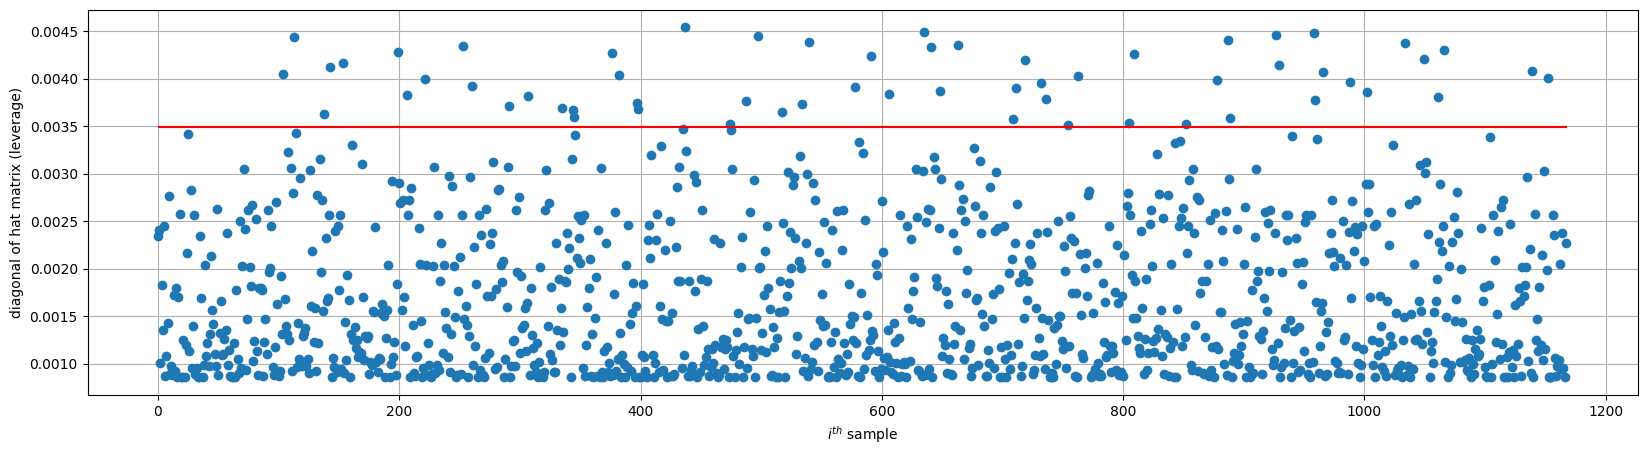

In [18]:
##### H_Matrix_Leverage (OUR WRITTEN CODE HERE)

target_column = ["SalePrice"]
feat_column   = ["GrLivArea"]

outliers_percentile = 5

def H_matrix_leverage(X_train):
    """
    Compute leverage scores (diagonal of the hat matrix H) for training inputs.

    Parameters
    ----------
    X_train : numpy array of shape (n_samples, n_features)
        Feature matrix (ONLY X, not including target y)

    Returns
    -------
    H_diag : numpy array of shape (n_samples,)
        Leverage score for each sample (diagonal elements of hat matrix)
    """

    n_samples, n_feats = X_train.shape

    X = np.hstack([np.ones((n_samples, 1)), X_train])
    XtX_inv = np.linalg.pinv(X.T @ X)
    XA = X @ XtX_inv
    H_diag = np.sum(XA * X, axis=1)

    return H_diag


X_train = train.loc[:, feat_column].values
[num_samples, num_feats] = X_train.shape

H_diag = H_matrix_leverage(X_train)

p_H = np.percentile(H_diag, 100 - outliers_percentile)

plt.figure(figsize=(20, 5))
plt.plot(H_diag, marker="o", ls='none')

plt.hlines(p_H, xmin=0, xmax=len(H_diag), colors="red")

plt.xlabel("$i^{th}$ sample")
plt.ylabel("diagonal of hat matrix (leverage)")
plt.grid()
plt.show()

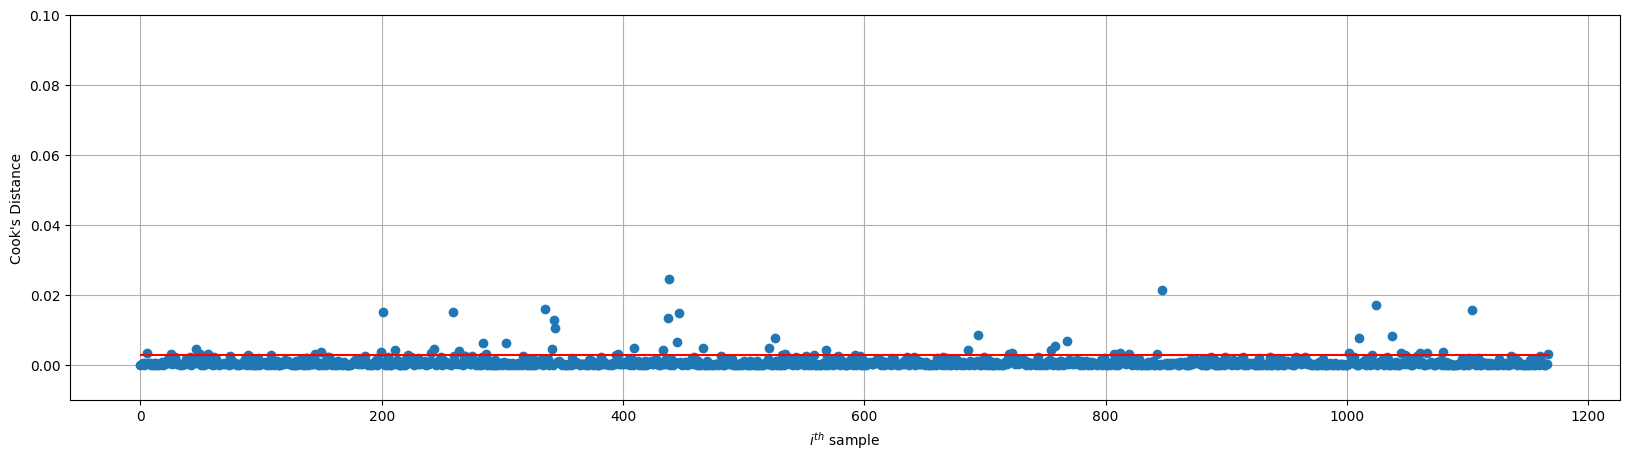

In [19]:
##### Cook's Distance (OUR WRITTEN CODE HERE)

from sklearn.linear_model import LinearRegression

X_train = train[feat_column].values
y_train = train[target_column].values

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_train_predict = model_lr.predict(X_train)
e_train = (y_train - y_train_predict).reshape(-1)
mse_train = np.mean((y_train - y_train_predict) ** 2)


def CookDistance(e_train, mse_train, H_diag, num_feats):
    """
    Compute Cook's Distance for each training sample.

    Parameters
    ----------
    e_train   : array of residuals (n_samples,)
    mse_train : mean squared error of the regression model
    H_diag    : leverage values (diagonal of hat matrix)
    num_feats : number of input features

    Returns
    -------
    Cook_D : array of Cook's Distance values (n_samples,)
    """

    p = num_feats + 1

    # Small value to avoid division by zero
    eps = 1e-12

    Cook_D = (e_train ** 2 / (p * (mse_train + eps))) * \
             (H_diag / ((1 - H_diag + eps) ** 2))

    return Cook_D

Cook_D = CookDistance(e_train, mse_train, H_diag, num_feats)
p_D = np.percentile(Cook_D, 100 - outliers_percentile)

plt.figure(figsize=(20, 5))
plt.plot(Cook_D, marker="o", ls='none')

plt.hlines(p_D, xmin=0, xmax=len(Cook_D), colors="red")

plt.xlabel("$i^{th}$ sample")
plt.ylabel("Cook's Distance")

plt.ylim([-0.01, 0.10])
plt.grid()
plt.show()


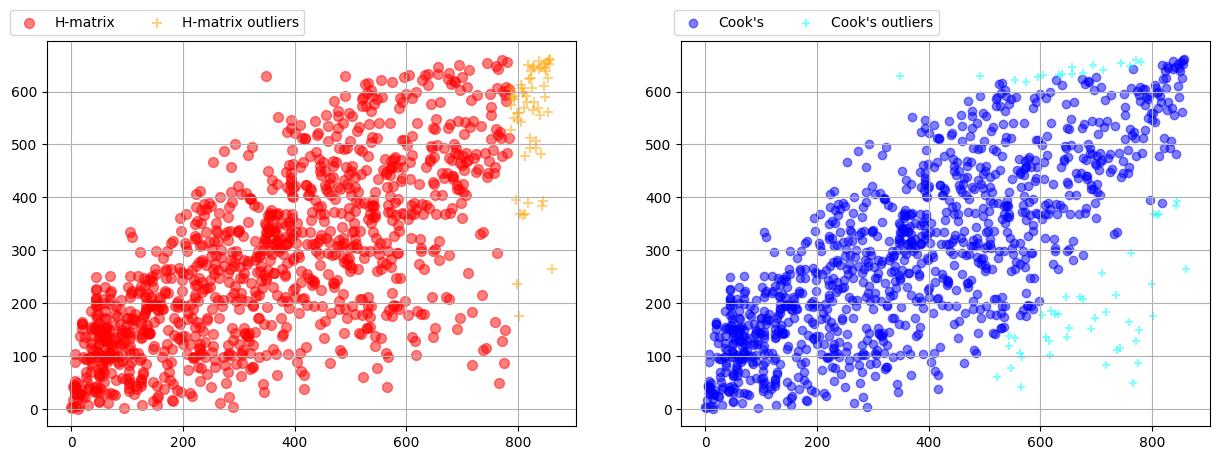

In [20]:

X_train_H = X_train[H_diag <= p_H, :]
Y_train_H = y_train[H_diag <= p_H]

X_train_H_outliers = X_train[H_diag > p_H, :]
Y_train_H_outliers = y_train[H_diag > p_H]

X_train_Cooks = X_train[Cook_D <= p_D, :]
Y_train_Cooks = y_train[Cook_D <= p_D]

X_train_Cooks_outliers = X_train[Cook_D > p_D, :]
Y_train_Cooks_outliers = y_train[Cook_D > p_D]

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

plt.scatter(
    X_train_H, Y_train_H,
    color="red", marker="o",
    label='H-matrix',
    s=50, alpha=0.5
)

plt.scatter(
    X_train_H_outliers, Y_train_H_outliers,
    color="orange", marker="+",
    label='H-matrix outliers',
    s=50, alpha=0.5
)

plt.legend(bbox_to_anchor=(0.50, 1.1), ncol=2)
plt.grid()

plt.subplot(1, 2, 2)

plt.scatter(
    X_train_Cooks, Y_train_Cooks,
    color="blue",
    label="Cook's",
    alpha=0.5
)

plt.scatter(
    X_train_Cooks_outliers, Y_train_Cooks_outliers,
    color="cyan", marker="+",
    label="Cook's outliers",
    alpha=0.5
)

plt.xlabel("")
plt.legend(bbox_to_anchor=(0.50, 1.1), ncol=2)
plt.grid()

plt.show()

In [21]:
X_test = test[feat_column].values
y_test = test[target_column].values

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_predict_test = model_lr.predict(X_test)

model_lr_H = LinearRegression()
model_lr_H.fit(X_train_H, Y_train_H)

y_predict_H_test = model_lr_H.predict(X_test)

model_lr_D = LinearRegression()
model_lr_D.fit(X_train_Cooks, Y_train_Cooks)

y_predict_D_test = model_lr_D.predict(X_test)

MSE_before = np.sqrt(np.mean((y_predict_test - y_test) ** 2))
MSE_after_H = np.sqrt(np.mean((y_predict_H_test - y_test) ** 2))
MSE_after_D = np.sqrt(np.mean((y_predict_D_test - y_test) ** 2))

print("RMSE [before outlier removal]        = %.2f" % MSE_before)
print("RMSE [after using H-matrix]          = %.2f" % MSE_after_H)
print("RMSE [after using Cook's Distance]  = %.2f" % MSE_after_D)

RMSE [before outlier removal]        = 114.78
RMSE [after using H-matrix]          = 114.96
RMSE [after using Cook's Distance]  = 115.38


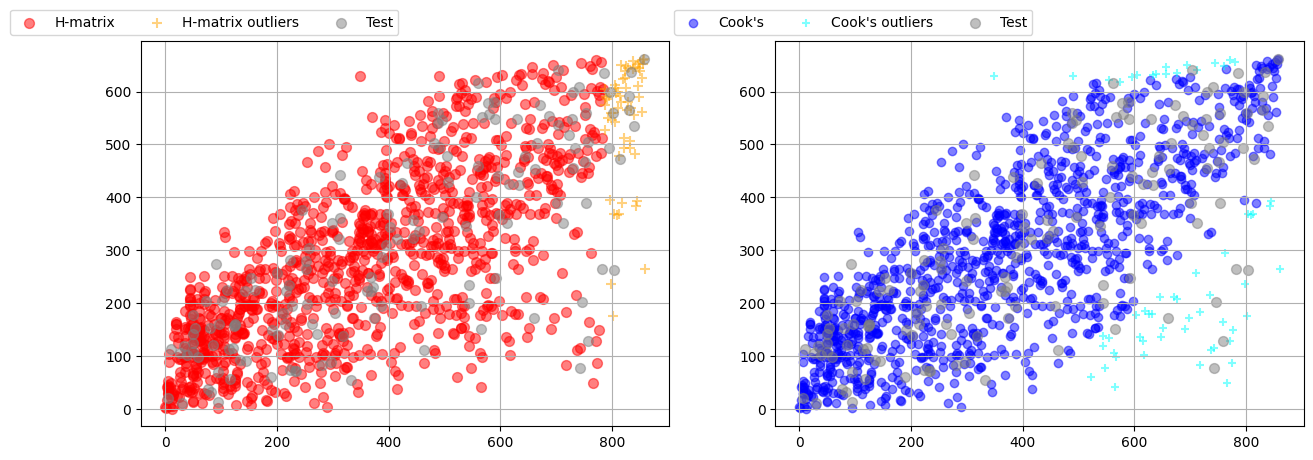

In [22]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

plt.scatter(
    X_train_H, Y_train_H,
    color="red", marker="o",
    label='H-matrix',
    s=50, alpha=0.5
)

plt.scatter(
    X_train_H_outliers, Y_train_H_outliers,
    color="orange", marker="+",
    label='H-matrix outliers',
    s=50, alpha=0.5
)

plt.scatter(
    X_test, y_test,
    color="grey", marker="o",
    label='Test',
    s=50, alpha=0.5
)

plt.legend(bbox_to_anchor=(0.50, 1.1), ncol=3)
plt.grid()

plt.subplot(1, 2, 2)

plt.scatter(
    X_train_Cooks, Y_train_Cooks,
    color="blue",
    label="Cook's",
    alpha=0.5
)

plt.scatter(
    X_train_Cooks_outliers, Y_train_Cooks_outliers,
    color="cyan", marker="+",
    label="Cook's outliers",
    alpha=0.5
)

plt.scatter(
    X_test, y_test,
    color="grey", marker="o",
    label='Test',
    s=50, alpha=0.5
)

plt.xlabel("")
plt.legend(bbox_to_anchor=(0.50, 1.1), ncol=3)
plt.grid()

plt.show()